### Sprint 2: Model Development

In [2]:
# Feature Engineering for Water Pump Classification
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data_path = os.path.join(os.getcwd(), '..', 'data')
out_path = os.path.join(os.getcwd(), '..', 'outputs')     # For the output

# Read the files
train = pd.read_csv(os.path.join(data_path, 'cleaned_data_filled_V6.csv'))
labels = pd.read_csv(os.path.join(data_path, 'train_labels.csv'))

# Merge training labels
df = pd.merge(train, labels, on='id')
print('Files successfully loaded and merged!')


Files successfully loaded and merged!


## Ticket 2.1.1: New Features 

In [4]:
# Age of pump
current_year = 2025
df['pump_age'] = current_year - df['construction_year']

# Manual vs. motorized extraction
df['is_manual_pump'] = df['extraction_type_class'].str.lower().str.contains('hand').astype(int)

# water_risk_score

# 1. Water Quality + Quantity Combination: Create 'water_risk_score'
# Map water_quality into numeric risk levels
water_quality_map = {
    'soft': 1, 'good': 1,
    'salty': 2, 'milky': 2,
    'coloured': 3, 'fluoride': 3, 'fluoride, salty': 4, 'salty abandoned': 4
}
df['water_quality_numeric'] = df['water_quality'].map(water_quality_map)

# Combine amount_tsh_capped and water quality
df['water_risk_score'] = df['amount_tsh_capped'] * df['water_quality_numeric']

## Ticket 2.1.2: Transform existing features to improve model performance 

In [5]:
# First we want to see distribution of all numerical values, Select only numerical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

#  Drop ID and target columns
numerical_cols = [col for col in numerical_cols if col not in ['id', 'status_group_numeric']]

#Calculate skewness
from scipy.stats import skew
skewness_results = {}

for col in numerical_cols:
    skew_val = skew(df[col].dropna())
    skewness_results[col] = skew_val

# Sort by skewness
skewness_sorted = dict(sorted(skewness_results.items(), key=lambda item: abs(item[1]), reverse=True))

# Show results
print("Feature Skewness:")
for feature, skew_val in skewness_sorted.items():
    print(f"{feature}: {skew_val:.3f}")




Feature Skewness:
num_private: 90.521
amount_tsh: 56.938
water_risk_score: 8.917
amount_tsh_capped: 8.062
district_code: 3.902
population: 3.699
water_quality_numeric: 3.483
region_code: 3.142
pump_age: 1.232
construction_year: -1.232
is_manual_pump: 1.073
gps_height: -0.612
latitude: -0.252
recorded_year: -0.145
longitude: -0.135


#### Decision Based on Skewness Analysis
Apply log1p transformation (log(x+1)) to the following features to reduce skewness:num_private, amount_tsh, water_risk_score, amount_tsh_capped ,population, pump_age

#### For other features, no transformation is necessary at this stage.

#### New features will be saved with a _log suffix (e.g., amount_tsh_log) to preserve original columns.


In [6]:
# List of skewed columns for log-transform
skewed_cols = ['amount_tsh', 'water_risk_score', 'amount_tsh_capped', 'population' ]

# Apply log1p transformation and create new columns with _log suffix
for col in skewed_cols:
    df[col + '_log'] = np.log1p(df[col].astype(float))

In [7]:
#check the skewness after log-transforming
for col in skewed_cols:
    print(f"{col}_log skewness: {skew(df[col + '_log'].dropna()):.3f}")

amount_tsh_log skewness: 1.290
water_risk_score_log skewness: 1.238
amount_tsh_capped_log skewness: 1.281
population_log skewness: -1.278


#### num_private is extremely sparse: most pumps have no private owner (value = 0).
#### Only a tiny number of pumps have some private ownership information.
#### It's not a continuous variable in reality — it behaves like a binary feature (yes/no private ownership). 0 → No private owner 1 → Private owner exists

In [8]:
df['has_private_owner'] = (df['num_private'] > 0).astype(int)


In [9]:
# Bin pump_age into categories
df['pump_age_binned'] = pd.cut(
    df['pump_age'],
    bins=[0, 10, 30, 100],
    labels=['young', 'medium', 'old']
)

In [10]:
df.to_csv(os.path.join(data_path,"feature_engineered_data_V1.csv"), index=False)
print('Data saved successfully: feature_engineered_data_V1.csv')

Data saved successfully: feature_engineered_data_V1.csv


#### Spearman Correlation for Numerical Variables

In [11]:
data_path = os.path.join(os.getcwd(), '..', 'data')
out_path = os.path.join(os.getcwd(), '..', 'outputs')     # For the output

# Read the files
train = pd.read_csv(os.path.join(data_path, 'feature_engineered_data_V1.csv'))
labels = pd.read_csv(os.path.join(data_path, 'train_labels.csv'))

# Drop status_group if it already exists in train
if 'status_group' in train.columns:
    train = train.drop(columns=['status_group'])
# Merge training labels
df = pd.merge(train, labels, on='id')
print('Files successfully loaded and merged!')

Files successfully loaded and merged!


In [12]:
numerical_cols= df.select_dtypes(include=np.number).columns
print("Numerical columns:", numerical_cols)

Numerical columns: Index(['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude',
       'num_private', 'region_code', 'district_code', 'population',
       'construction_year', 'recorded_year', 'amount_tsh_capped', 'pump_age',
       'is_manual_pump', 'water_quality_numeric', 'water_risk_score',
       'amount_tsh_log', 'water_risk_score_log', 'amount_tsh_capped_log',
       'population_log', 'has_private_owner'],
      dtype='object')


In [13]:
# Drop redundant originals columns
drop_cols = ['amount_tsh', 'amount_tsh_capped', 'population', 'water_risk_score']
numerical_cols = [col for col in numerical_cols if col not in drop_cols]

print(numerical_cols)

['id', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'construction_year', 'recorded_year', 'pump_age', 'is_manual_pump', 'water_quality_numeric', 'amount_tsh_log', 'water_risk_score_log', 'amount_tsh_capped_log', 'population_log', 'has_private_owner']


In [14]:
# Compute Spearman correlation (good for both linear and monotonic relationships)
from scipy.stats import spearmanr
spearman_corr = df[numerical_cols].corr(method='spearman')

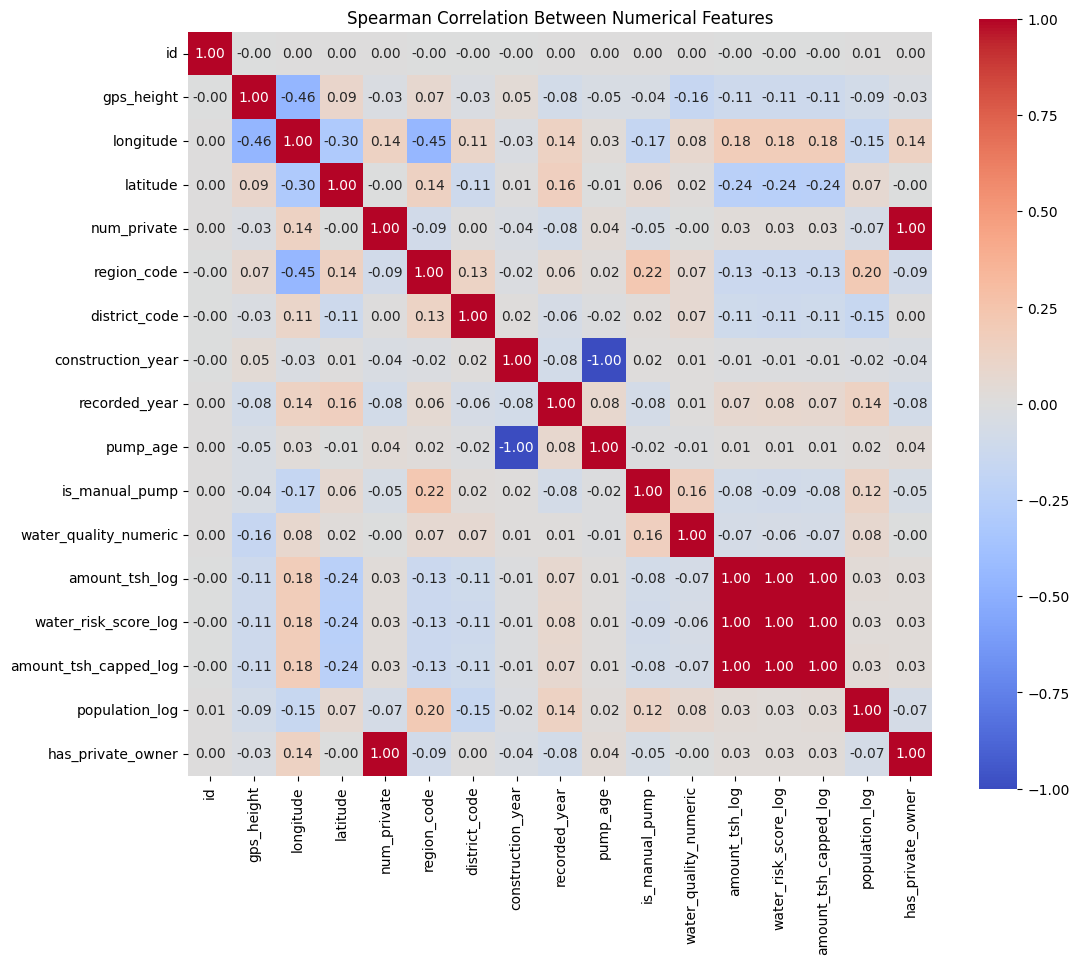

In [15]:
plt.figure(figsize=(12, 10))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Spearman Correlation Between Numerical Features")
plt.savefig(os.path.join(out_path,"pearmanCorrelationBetweenNumerical.png"))
plt.show()

In [16]:
df.to_csv(os.path.join(data_path,'feature_engineered_data_cleaned_V1.csv'),index=False)
print("Cleaned feature data saved as: feature_engineered_data_cleaned_V1.csv")

Cleaned feature data saved as: feature_engineered_data_cleaned_V1.csv


Correlation: Categorical vs. Categorical — Using Cramér’s V

In [17]:
from scipy.stats import chi2_contingency
data_path = os.path.join(os.getcwd(), '..', 'data')
out_path = os.path.join(os.getcwd(), '..', 'outputs')   
# Read the files
train = pd.read_csv(os.path.join(data_path, 'feature_engineered_data_cleaned_V1.csv'))
labels = pd.read_csv(os.path.join(data_path, 'train_labels.csv'))

# Drop status_group if it already exists in train
if 'status_group' in train.columns:
    train = train.drop(columns=['status_group'])
# Merge training labels
df = pd.merge(train, labels, on='id')
print('Files successfully loaded and merged!')

Files successfully loaded and merged!


In [18]:


def cramers_v(confusion_matrix):
    """Calculate Cramér's V statistic for categorical-categorical association."""
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))


In [19]:
# Select all object-type columns (categorical features)
cat_cols = df.select_dtypes(include='object').columns.tolist()
print("Categorical columns:", cat_cols)


Categorical columns: ['date_recorded', 'funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'status_group_x', 'status_group_y', 'pump_age_binned', 'status_group']


In [20]:
drop_cat_cols = [
    'date_recorded',
    'wpt_name',
    'subvillage',
    'ward',
    'recorded_by',
    'scheme_name',
    'extraction_type_group',
    'extraction_type_class',
    'management_group',
    'payment_type',
    'quality_group',
    'quantity_group',
    'source_type',
    'source_class',
    'waterpoint_type_group'
    'water_quality',
    'water_risk_score'
]


# Drop columns safely (only if they exist)
df = df.drop(columns=[col for col in drop_cat_cols if col in df.columns])
# List of log-transformed numeric features
log_cols = ['amount_tsh_log', 'population_log', 'water_risk_score_log', 'amount_tsh_capped_log']

for col in log_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df.to_csv(os.path.join(data_path, 'feature_engineered_data_V2.csv'), index=False)
print("Updated dataset saved as feature_engineered_data_V2.csv")

Updated dataset saved as feature_engineered_data_V2.csv


In [21]:
# Store results in a list
cramers_results = []


strongly corelation between categorical values will be investigating, before that some columns will be deleted based on previous investigations

In [22]:
cat_cols_filtered = [
    'funder', 'installer', 'region', 'public_meeting',
    'scheme_management', 'permit', 'extraction_type',
    'management', 'payment', 'quantity',
    'source', 'waterpoint_type', 'pump_age_binned', 'status_group'
]

In [23]:
for i in range(len(cat_cols_filtered)):
    for j in range(i + 1, len(cat_cols_filtered)):
        col1, col2 = cat_cols_filtered[i], cat_cols_filtered[j]
        try:
            confusion = pd.crosstab(df[col1], df[col2])
            score = cramers_v(confusion)
            cramers_results.append((col1, col2, score))
        except:
            continue

In [24]:
# Convert to DataFrame and sort
cramers_df = pd.DataFrame(cramers_results, columns=['Feature A', 'Feature B', 'Cramers V'])
cramers_df = cramers_df.sort_values(by='Cramers V', ascending=False)

# Show top results
print(cramers_df.head(15))


            Feature A          Feature B  Cramers V
48  scheme_management         management   0.790538
0              funder          installer   0.767695
13          installer             region   0.737078
1              funder             region   0.727542
11             funder    pump_age_binned   0.667608
16          installer             permit   0.652502
15          installer  scheme_management   0.647156
3              funder  scheme_management   0.614877
23          installer    pump_age_binned   0.614527
4              funder             permit   0.614113
18          installer         management   0.587543
6              funder         management   0.580021
9              funder             source   0.540077
21          installer             source   0.526620
19          installer            payment   0.519874


In [25]:
drop_based_on_cramers = [
    'scheme_management',  # drop in favor of 'management'
    'installer',          # very redundant with region + funder
    'funder'              # also strongly tied to region and messy
]

In [26]:
df = df.drop(columns=drop_based_on_cramers)

In [27]:
df.to_csv(os.path.join(data_path, 'feature_engineered_data_final_v3.csv'), index=False)
print("Updated dataset saved as feature_engineered_data_final_v3.csv")


Updated dataset saved as feature_engineered_data_final_v3.csv


Does region affect amount_tsh_log?

In [28]:
from scipy.stats import f_oneway

def anova_test(cat_col, num_col):
    groups = [df[df[cat_col] == level][num_col].dropna() for level in df[cat_col].unique()]
    stat, p = f_oneway(*groups)
    return stat, p

f_stat, p_val = anova_test('region', 'amount_tsh_log')
print(f"ANOVA F={f_stat:.2f}, p-value={p_val:.3e}")


ANOVA F=1134.97, p-value=0.000e+00


 statistically significant difference in amount_tsh_log across different region values

In [29]:
categorical_vars = ['region', 'quantity', 'payment', 'pump_age_binned']
numerical_vars = ['amount_tsh_log', 'population_log', 'gps_height', 'water_risk_score_log']


Use logistic regression with cross-validation to: Get a baseline performance, Optionally use feature importance (coefficients) for feature selection

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

data_path = os.path.join(os.getcwd(), '..', 'data')
out_path = os.path.join(os.getcwd(), '..', 'outputs')

#loading datasets

train = pd.read_csv(os.path.join(data_path, 'feature_engineered_data_final_v3.csv'))
labels = pd.read_csv(os.path.join(data_path, 'train_labels.csv'))

# Drop status_group if it already exists in train
if 'status_group' in train.columns:
    train = train.drop(columns=['status_group'])
df = train.merge(labels, on='id')
df = df.drop(columns=['region','lga', 'extraction_type', 'management']) #for now
df['water_quality_numeric'] = df['water_quality_numeric'].fillna(0)
df['water_risk_score_log'] = df['water_risk_score_log'].fillna(0)


In [35]:
# all categorical features (excluding target)
categorical_cols = df.select_dtypes(include='object').columns.tolist()
categorical_cols = [col for col in categorical_cols if col != 'status_group']

# One-hot encode medium-cardinality features (3 to 10 unique values)
onehot_cols = [col for col in categorical_cols if 2 < df[col].nunique() <= 10]
df_encoded = pd.get_dummies(df, columns=onehot_cols, drop_first=True)

# Label encode low-cardinality features (≤ 2 unique values)
label_enc_cols = [col for col in categorical_cols if df[col].nunique() <= 2]

label_encoders = {}
for col in label_enc_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df[col].astype(str)) 
    label_encoders[col] = le

In [ ]:
# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(df['status_group']) 

leak_cols = [col for col in df_encoded.columns if 'status_group_' in col or 'status_group.' in col]
df_encoded = df_encoded.drop(columns=leak_cols)

# Define features and target
X = df_encoded.drop(columns=['status_group','id'])
y = y_encoded
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Initialize the model
model = LogisticRegression( solver='lbfgs', max_iter=2000)



In [37]:
# Run 5-fold cross-validation
scores = cross_val_score(model, X_scaled, y, cv=5, scoring='accuracy')

# Print results
print("Cross-validation scores:", scores)
print("Mean accuracy:", scores.mean())

Cross-validation scores: [0.73016149 0.72781733 0.72443132 0.7237996  0.7327429 ]
Mean accuracy: 0.7277905286074386


Using Cross-Validation to Tune Parameters (with GridSearchCV)

In [44]:
# pipeline with scaling + model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000))
])

# parameter grid to search
param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10],
    'logreg__penalty': ['l2'],
    'logreg__solver': ['lbfgs', 'saga']
}


In [45]:
# GridSearch with 5-fold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

In [43]:
# Run search
grid_search.fit(X, y)

# Show best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best CV accuracy:", grid_search.best_score_)

d:\script\Datacircle\water_pumps\.venv\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best parameters: {'logreg__C': 0.01, 'logreg__penalty': 'l2', 'logreg__solver': 'saga'}
Best CV accuracy: 0.7278773582821911


In [47]:
print(type(grid_search))

<class 'sklearn.model_selection._search.GridSearchCV'>


In [46]:
import joblib
joblib.dump(grid_search.best_estimator_, 'best_logistic_model.pkl')

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'